# Imports

In [1]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pandas as pd

# Constants
## For styling

In [2]:
colors = [(255,0,0), (127,0,255), (0,127,0), (0,127,255)]
line_padding = [0.7, 1.5,1.5,1.5]

font_scale = 1
text_position_cnt = (100, 100)
text_position_time = (100, 120)

output_folder_video = "../output/video"
output_folder_csv = "../output/csv"

## For algorithm tuning

In [3]:
# Are for optime
kernel = np.ones((5,5),np.uint8)
threshold_area_size = [10, 10, 10, 5]
video_path = "../VID_20231216_032635.mp4"
frame_shift = 500
set_fps = 150 # I dont know if its work

video_name = "test_01_my_hand"

## Support functions

In [4]:
# Add text overlay into video frame
def add_text_to_frame(frame, text, position=(30, 30), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.2, color=(0, 255, 0), thickness=2):
    """
    Add text to a frame.

    Parameters:
    - frame (numpy.ndarray): Input frame.
    - text (str): Text to be added to the frame.
    - position (tuple): Position of the text (x, y).
    - font (int): Font type.
    - font_scale (float): Font scale.
    - color (tuple): Text color (B, G, R).
    - thickness (int): Text thickness.

    Returns:
    - numpy.ndarray: Frame with added text.
    """
    frame_with_text = frame.copy()
    cv2.putText(frame_with_text, text, position, font, font_scale, color, thickness)
    return frame_with_text

In [5]:
def calculate_angle(line1, line2):
    # Convert lines to numpy arrays
    line1 = np.array(line1)
    line2 = np.array(line2)

    # Calculate the vectors corresponding to the lines
    vector1 = line1[1] - line1[0]
    vector2 = line2[1] - line2[0]

    # Calculate the dot product and cross product of the vectors
    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)

    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine of the angle between the vectors
    cosine_theta = dot_product / (magnitude1 * magnitude2)

    # Determine the sign of the dot product to determine the direction
    if dot_product > 0:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = 180 - np.degrees(angle_radians)
        # Adjust angle for the cross product sign
        if cross_product < 0:
            angle_degrees = 360 - angle_degrees
    else:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [6]:
def calculate_vector(point1, point2):
    return np.array(point2) - np.array(point1)

In [7]:
# def segment_marker_by_color(frame_tmp):
#     # Input must be a frame in the cielab color model from the OpenCV function
#
#     # Extract color channels
#     L_channel = frame_tmp[:, :, 0]
#     a_channel = frame_tmp[:, :, 1]
#     b_channel = frame_tmp[:, :, 2]
#
#     # Color segmentation using NumPy array operations
#     marker_blue = (a_channel > 140) & (a_channel < 170) & (b_channel > 160)
#     marker_pink = (a_channel > 175) & (b_channel < 80)
#     marker_green = (a_channel < 120) & (b_channel > 130)
#     marker_yellow = (a_channel > 80) & (a_channel < 120) & (b_channel > 90) & (b_channel < 110)
#
#     return marker_blue, marker_pink, marker_green, marker_yellow

In [8]:
def find_intersection(p1, p2, q1, q2):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1
    x4, y4 = q2

    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det != 0:
        px = int(((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det)
        py = int(((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det)
        return px, py
    else:
        return None

def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [9]:
def main_function(frame, swap):
    # Convert the input frame to the CIELAB color space
    cielab_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2Lab)

    # Segment markers by color in the CIELAB color space
    marker_blue, marker_pink, marker_green, marker_yellow = segment_marker_by_color(cielab_frame)

    # Create a stack of masks for each color marker
    masks = np.stack([marker_blue, marker_pink, marker_green, marker_yellow], axis=0)

    # Define color names for visualization
    colors_name = ["blue", "pink", "green", "yellow"]

    # Initialize a list to store points per frame
    point_per_frame = []

    # Set the line padding value
    line_pad = 5  # Adjust this value as needed

    # Initialize the direction vector for the first line
    direction_vector_0_1 = None

    # Iterate over each color marker
    for mask, thr, color, color_name, direction_vector in zip(
            masks, threshold_area_size, colors, colors_name, [direction_vector_0_1, None, None, None]
    ):
        # Convert the mask to uint8
        mask = np.uint8(mask)

        # Find connected components in the mask
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

        # Filter regions based on area threshold
        filtered_regions = [index for index, stat in enumerate(stats[1:]) if stat[4] >= thr]

        # Initialize a list to store points per mask
        point_per_mask = []

        # Iterate over filtered regions in the mask
        for idx, index in enumerate(filtered_regions):
            # Access region properties from the stats array
            left, top, width, height, area = stats[index + 1]

            # Calculate the centroid
            centroid_x, centroid_y = int(left + width / 2), int(top + height / 2)

            # Append the centroid to the list of points for the mask
            point_per_mask.append((centroid_x, centroid_y))

        # # Visualize circles for each point in the mask
        # for idx, point in enumerate(point_per_mask):
        #     cv2.circle(frame, (point[0], point[1]), radius=idx * 3, color=color, thickness=5)

        # Visualize circles for each point with increased radius
        for idx, point in enumerate(point_per_mask):
            cv2.circle(frame, (point[0], point[1]), radius=idx * 5 + 3, color=color, thickness=5)

        print(point_per_mask)
        print("________________")
        try:
            # If direction vector is not initialized, calculate it from the first two points
            if direction_vector is None:
                direction_vector = calculate_vector(point_per_mask[1], point_per_mask[0])
        except Exception as e:
            print(e)
            print(color_name)
            print(point_per_mask)
            print(filtered_regions)

        # Calculate points for the line based on the direction vector and line padding
        point1 = (
            int(point_per_mask[1][0] - line_pad * direction_vector[0]),
            int(point_per_mask[1][1] - line_pad * direction_vector[1]),
        )
        point2 = (
            int(point_per_mask[0][0] + line_pad * direction_vector[0]),
            int(point_per_mask[0][1] + line_pad * direction_vector[1]),
        )

        # Visualize the line connecting the two points
        cv2.line(frame, point1, point2, color, 3)

        # Append the points for the current mask to the list of points per frame
        point_per_frame.append(point_per_mask)

    # Find the intersection point
    intersection_point_0 = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    intersection_point_1 = find_intersection(point_per_frame[1][0], point_per_frame[1][1], point_per_frame[2][0], point_per_frame[2][1])
    intersection_point_2 = find_intersection(point_per_frame[2][0], point_per_frame[2][1], point_per_frame[3][0], point_per_frame[3][1])

    # Here is calculated that tip point must be selected as intersections point
    if calculate_distance(point_per_frame[3][0], point_per_frame[0][0]) < calculate_distance(point_per_frame[3][0], point_per_frame[0][1]):
        trajectory_point_0 = point_per_frame[0][0]
    else:
        trajectory_point_0 = point_per_frame[0][1]

    if calculate_distance(point_per_frame[0][0], point_per_frame[1][0]) > calculate_distance(point_per_frame[0][0], point_per_frame[1][1]):
        trajectory_point_1 = point_per_frame[1][0]
    else:
        trajectory_point_1 = point_per_frame[1][1]



    if calculate_distance(point_per_frame[2][0], point_per_frame[3][0]) > calculate_distance(point_per_frame[2][0], point_per_frame[3][1]):
        trajectory_point_3 = point_per_frame[3][0]
    else:
        trajectory_point_3 = point_per_frame[3][1]

    if calculate_distance(point_per_frame[1][0], point_per_frame[2][0]) > calculate_distance(point_per_frame[1][0], point_per_frame[2][1]):
        trajectory_point_2 = point_per_frame[2][0]
    else:
        trajectory_point_2 = point_per_frame[2][1]

    # Draw the joint point
    cv2.circle(frame, trajectory_point_0, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_1, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_2, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_3, 2, (0, 0, 0), -1)


    # Draw the intersection point
    cv2.circle(frame, intersection_point_0, 2, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_1, 2, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_2, 2, (255, 255, 255), -1)


    # # Find the intersection point
    # intersection_point = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    #
    # # Draw the intersection point
    # if intersection_point:
    #     cv2.circle(frame, intersection_point, 10, (255, 255, 255), -1)

    # Calculate angles between consecutive lines
    angle_0 = calculate_angle(point_per_frame[0], point_per_frame[1])
    angle_1 = calculate_angle(point_per_frame[1], point_per_frame[2])
    angle_2 = calculate_angle(point_per_frame[2], point_per_frame[3])

    if np.isnan(angle_0):
        angle_0 = -1
    if np.isnan(angle_1):
        angle_1 = -1
    if np.isnan(angle_2):
        angle_2 = -1
    # Add text annotations to the frame with calculated angles
    frame = add_text_to_frame(frame, "ANGLE 0: {}".format(int(angle_0)), position=(900, 400), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 1: {}".format(int(angle_1)), position=(900, 420), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 2: {}".format(int(angle_2)), position=(900, 440), font_scale=0.5, thickness=2, color=(255, 255, 0))
    return frame, angle_0, angle_1, angle_2, trajectory_point_0, trajectory_point_1, trajectory_point_2, trajectory_point_3


In [10]:

def store_video(frames, output_path, fps):


    # Function to store the video with updated frames
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()

[ WARN:0@2.393] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@2.393] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@2.393] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@2.393] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16645483

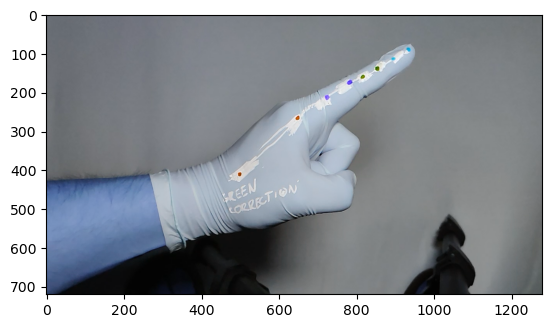

In [11]:
cap = cv2.VideoCapture("../VID_20231216_133508.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 952)
cap.set(cv2.CAP_PROP_FPS, set_fps)
# cap.set(cv2.SET_)
ret, frame = cap.read()
# frame = cv2.rotate(frame, cv2.ROTATE_180)
plt.imshow(frame)
# Use the original frame instead of creating a copy
# frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3  = main_function(frame, False)
#
# # Add text to the frame
# frame = add_text_to_frame(frame, str(frame_shift), position=text_position_cnt, font_scale=font_scale)
#
# # Calculate and add time information
# end = time.time()
# frame = add_text_to_frame(frame, "0", position=text_position_time, font_scale=font_scale)
#
# plt.figure(figsize=(20,20))
# plt.imshow(frame)
# # measure.append([cnt, angle_0,angle_1,angle_2])

In [12]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 145)
    marker_pink = (a_channel > 160) & (b_channel < 80)
    marker_green = (a_channel < 115) & (b_channel > 130)
    marker_yellow = (a_channel > 40) & (a_channel < 120) & (b_channel > 40) & (b_channel < 110)

    # Remove for prod recording -> now i have only for delete another object
    marker_blue[600:,:300] = 0
    marker_pink[600:] = 0
    marker_green[:,1000:] = 0
    marker_green[600:,:300] = 0
    marker_yellow[600:,:300] = 0
    kernel = np.ones((5,5),np.uint8)
    marker_green = cv2.dilate(np.uint8(marker_green*255),kernel,iterations = 1)
    marker_yellow = cv2.dilate(np.uint8(marker_yellow*255),kernel,iterations = 1)

    return marker_blue, marker_pink, marker_green, marker_yellow


NameError: name 'mmm' is not defined

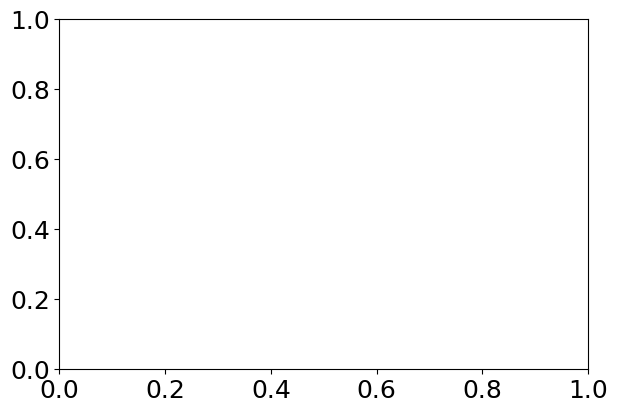

In [13]:
plt.figure(figsize= (15, 10))
plt.rcParams['font.size']=18
plt.subplot(221)
plt.imshow(mmm[0])
plt.subplot(222)
plt.imshow(mmm[1])
# plt.colorbar()
plt.title('L')
plt.subplot(223)
plt.imshow(mmm[2])
# plt.colorbar()
plt.title('a')
plt.subplot(224)
plt.imshow(mmm[3])
# plt.colorbar()
plt.title('b')

[ WARN:0@4.842] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@4.842] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin1 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@4.842] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@4.842] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16645483

29.968154907226562
[(654, 273), (498, 409)]
________________
[(813, 247), (744, 251)]
________________
[(837, 267), (871, 292)]
________________
[(904, 327), (931, 367)]
________________


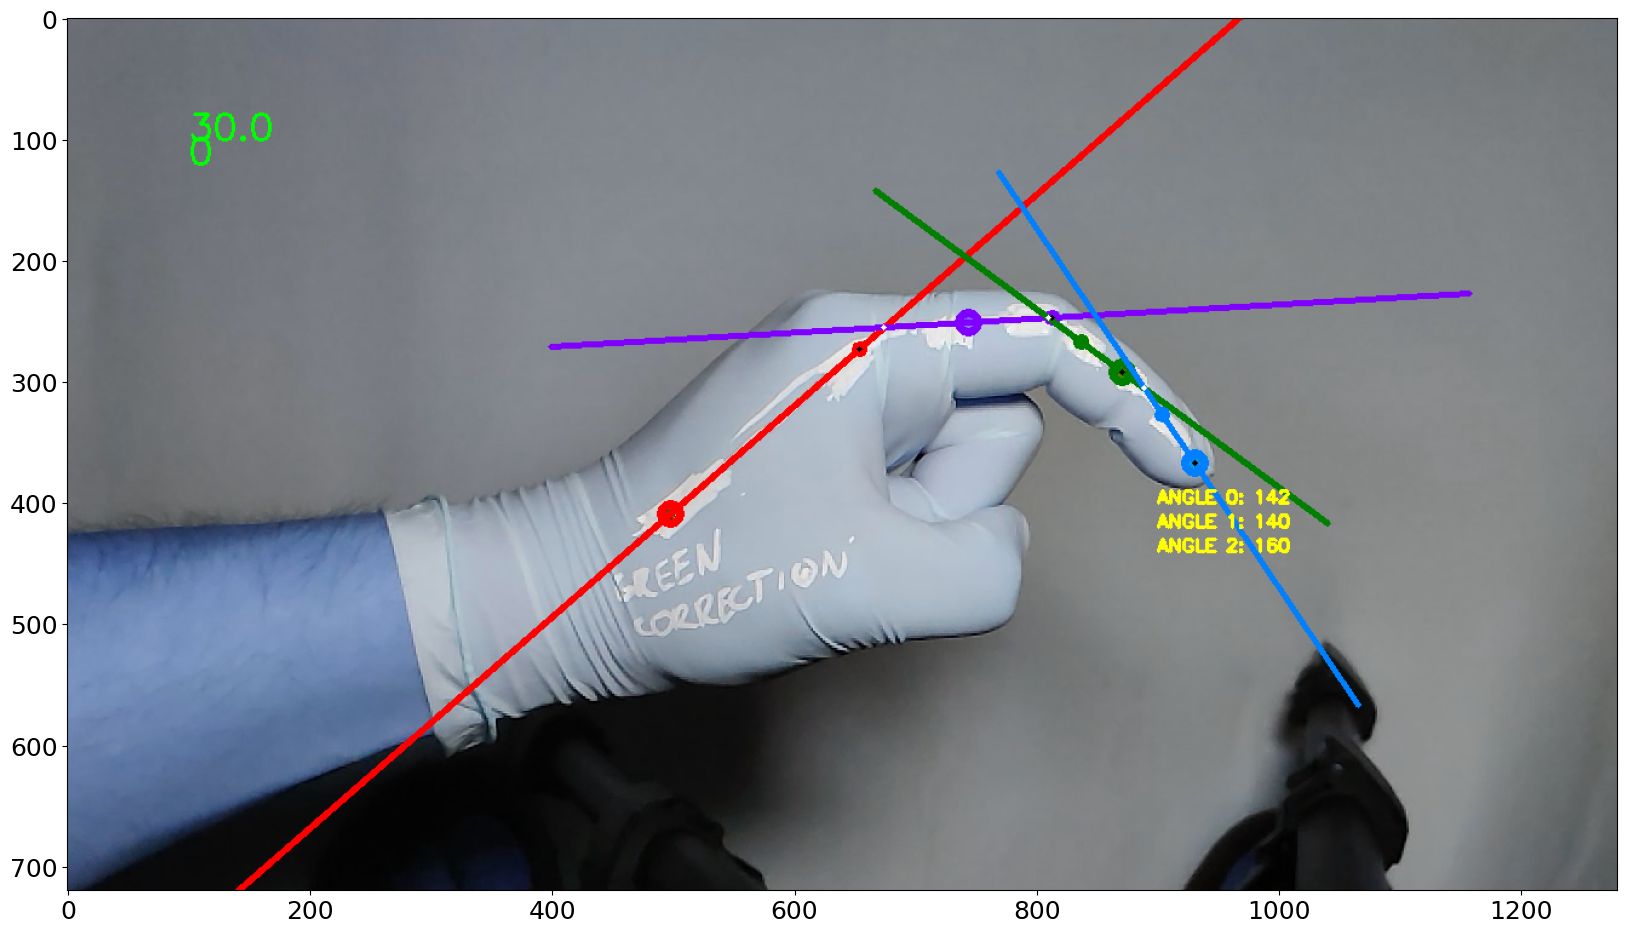

In [14]:
cap = cv2.VideoCapture("../VID_20231216_133508.mp4")
normalizedFPS = round(1000.0 * 28.9) / 1000.0;
cap.set(cv2.CAP_PROP_POS_FRAMES, normalizedFPS)
# cap.set(cv2.CAP_PROP_FPS, 480)
print(cap.get(cv2.CAP_PROP_FPS))# cap.set(cv2.SET_)
ret, frame = cap.read()

# Use the original frame instead of creating a copy
frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3  = main_function(frame, False)

# Add text to the frame
frame = add_text_to_frame(frame, str(cap.get(1)), position=text_position_cnt, font_scale=font_scale)

# Calculate and add time information
end = time.time()
frame = add_text_to_frame(frame, "0", position=text_position_time, font_scale=font_scale)

plt.figure(figsize=(20,20))
plt.imshow(frame)
# measure.append([cnt, angle_0,angle_1,angle_2])

# Main logic

In [15]:
import cv2
import time

# Add the necessary functions for main_function and add_text_to_frame
frame_shift = 0
cap = cv2.VideoCapture("../VID_20231216_133508.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 3000)
# cap.set(cv2.CAP_PROP_FPS, frame_shift)

if not cap.isOpened():
    print("Error: Could not open the video file.")
    exit()

# Create a window to display the frames
cv2.namedWindow('Video Preview', cv2.WINDOW_NORMAL)

measure = []  # for storing angles
frames_to_store = []
cnt = frame_shift  # for storing frame count
paused = False

while True:
    # print(cnt)
    strt = time.time()

    if not paused:
        ret, frame = cap.read()
        # bckp_frame = frame.copy()
        if not ret:
            break

        # Use the original frame instead of creating a copy
        frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3 = main_function(frame, False)

        # Add text to the frame
        frame = add_text_to_frame(frame, str(cap.get(1)), position=text_position_cnt, font_scale=font_scale)

        # Calculate and add time information
        end = time.time()
        frame = add_text_to_frame(frame, str(end - strt), position=text_position_time, font_scale=font_scale)
        measure.append([cnt, angle_0, angle_1, angle_2, intersection_point_0[0], intersection_point_0[1], intersection_point_1[0], intersection_point_1[1], intersection_point_2[0], intersection_point_2[1], intersection_point_3[0], intersection_point_3[1]])

        cv2.imshow('Video Preview', frame)
        frames_to_store.append(frame.copy())
        cnt += 1

    key = cv2.waitKeyEx(1)  # Use cv2.waitKeyEx to capture arrow key presses

    if key == 27:  # Press 'Esc' to exit
        break
    elif key == 32:  # Press 'Space' to pause/unpause
        paused = not paused
    elif key == 97:  # Press left arrow key to move backward
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, cnt - 2))
        cnt -= 2
    elif key == 100:  # Press right arrow key to move forward
        cap.set(cv2.CAP_PROP_POS_FRAMES, cnt)
    elif key == 65364:  # Press down arrow key to move forward faster
        cap.set(cv2.CAP_PROP_POS_FRAMES, min(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1, cnt + 30))
        cnt += 30

cap.release()
cv2.destroyAllWindows()


[ WARN:0@7.523] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@7.523] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin2 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@7.523] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@7.523] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16645483

[(662, 279), (508, 419)]
________________
[(815, 230), (749, 245)]
________________
[(846, 242), (886, 256)]
________________
[(927, 278), (967, 303)]
________________
[(662, 279), (508, 419)]
________________
[(814, 230), (748, 245)]
________________
[(846, 242), (886, 256)]
________________
[(928, 276), (967, 303)]
________________
[(662, 279), (508, 419)]
________________
[(814, 230), (748, 245)]
________________
[(846, 242), (886, 255)]
________________
[(928, 276), (968, 301)]
________________
[(662, 279), (508, 419)]
________________
[(814, 230), (748, 245)]
________________
[(846, 241), (886, 255)]
________________
[(928, 276), (968, 301)]
________________
[(662, 279), (508, 419)]
________________
[(814, 230), (748, 245)]
________________
[(846, 241), (886, 255)]
________________
[(928, 275), (968, 301)]
________________
[(662, 279), (508, 419)]
________________
[(814, 230), (748, 245)]
________________
[(846, 241), (886, 254)]
________________
[(928, 275), (969, 299)]
_________

In [17]:
cap.release()
cv2.destroyAllWindows()

TypeError: Image data of dtype object cannot be converted to float

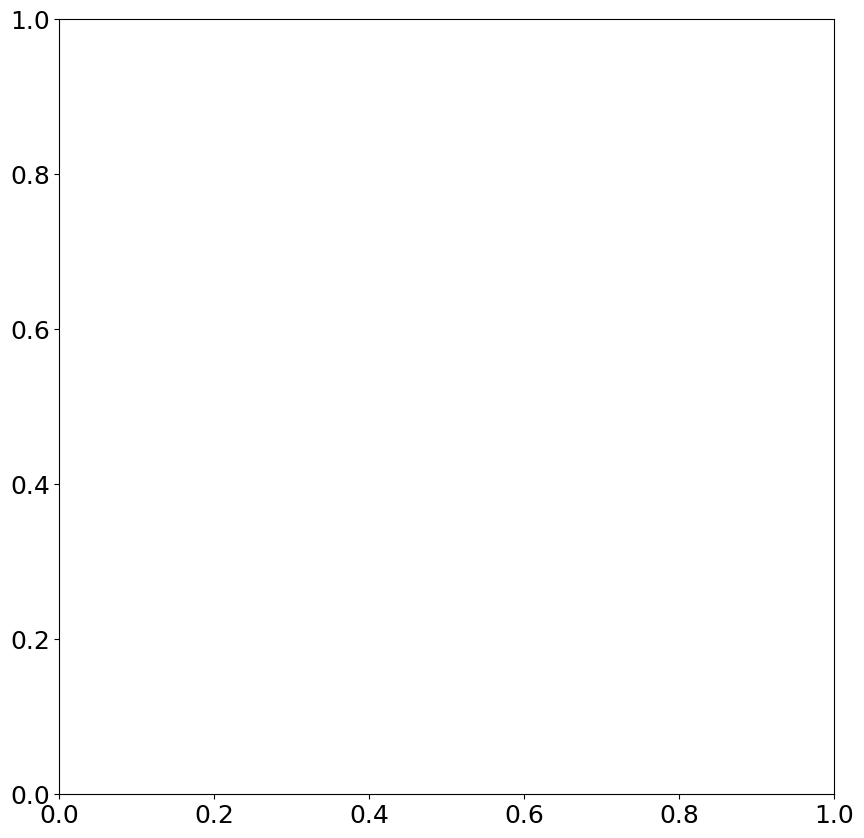

In [16]:
plt.figure(figsize=(10,20))
plt.imshow(frame)

In [139]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 145)
    marker_pink = (a_channel > 160) & (b_channel < 80)
    marker_green = (a_channel < 110) & (b_channel > 130)
    marker_yellow = (a_channel > 40) & (a_channel < 120) & (b_channel > 40) & (b_channel < 110)

    # Remove for prod recording -> now i have only for delete another object
    marker_blue[600:,:300] = 0
    marker_pink[600:] = 0
    marker_green[:,1000:] = 0
    marker_green[600:,:300] = 0
    marker_yellow[600:,:300] = 0
    kernel = np.ones((5,5),np.uint8)
    marker_green = cv2.dilate(np.uint8(marker_green*255),kernel,iterations = 1)
    marker_yellow = cv2.dilate(np.uint8(marker_yellow*255),kernel,iterations = 1)

    return marker_blue, marker_pink, marker_green, marker_yellow


mmm = segment_marker_by_color(cv2.cvtColor(bckp_frame, cv2.COLOR_RGB2Lab))


Text(0.5, 1.0, 'yellow')

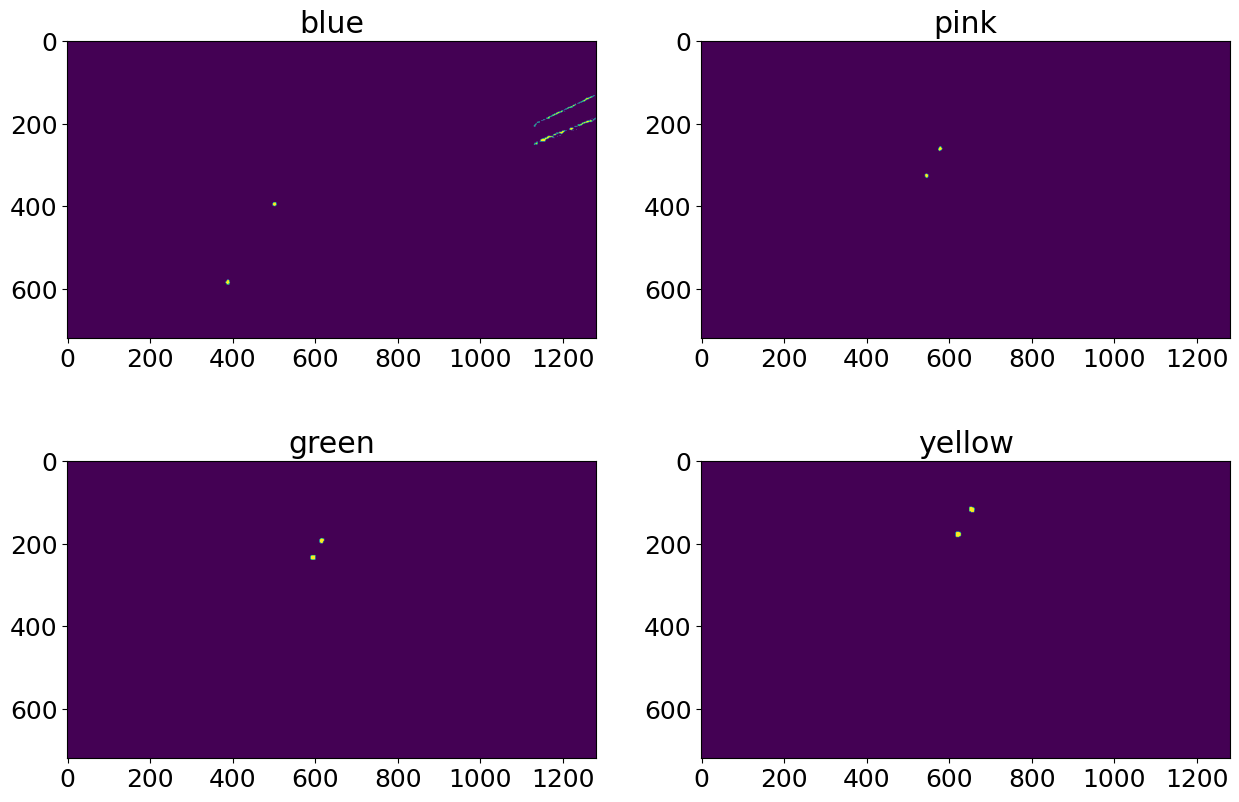

In [140]:
plt.figure(figsize= (15, 10))
plt.rcParams['font.size']=18
plt.subplot(221)
plt.title('blue')
plt.imshow(mmm[0])
plt.subplot(222)
plt.imshow(mmm[1])
# plt.colorbar()
plt.title('pink')
plt.subplot(223)
plt.imshow(mmm[2])
# plt.colorbar()
plt.title('green')
plt.subplot(224)
plt.imshow(mmm[3])
# plt.colorbar()
plt.title('yellow')

## Store processed video

In [18]:
# Store the video with updated frames
output_video_path = os.path.join(output_folder_video,f"{video_name}.mp4")  # Set the desired output video path
store_video(frames_to_store, output_video_path, set_fps)


(<unknown>:53905): GStreamer-CRITICAL **: 13:49:48.416: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@109.112] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
2023-12-16 13:49:48.643 python[53905:29481258] AVF: AVAssetWriter status: Cannot Save


## Store csv - raw_angles

In [19]:
df_angle = pd.DataFrame(data=measure, columns=["frame", "angle_0", "angle_1", "angle_2", "i_p_0_x", "i_p_0_y","i_p_1_x", "i_p_1_y","i_p_2_x", "i_p_2_y","i_p_3_x", "i_p_3_y"])
df_angle["time"] = df_angle["frame"] / set_fps
df_angle.to_csv(os.path.join(output_folder_csv,f"{video_name}.csv"), index=False)
df_angle

,frame,angle_0,angle_1,angle_2,i_p_0_x,i_p_0_y,i_p_1_x,i_p_1_y,i_p_2_x,i_p_2_y,i_p_3_x,i_p_3_y,time
0,0,150.530577,147.905688,167.284663,662,279,815,230,886,256,967,303,0.000000
1,1,150.530577,147.905688,164.594893,662,279,814,230,886,256,967,303,0.006667
2,2,150.530577,149.191572,165.998778,662,279,814,230,886,255,968,301,0.013333
3,3,150.530577,147.905688,167.284663,662,279,814,230,886,255,968,301,0.020000
4,4,150.530577,147.905688,166.266179,662,279,814,230,886,255,968,301,0.026667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,3008,129.157380,151.219199,173.028091,662,255,822,256,882,304,950,366,20.053333
3009,3009,128.955644,151.219199,173.028091,662,254,822,256,882,303,951,365,20.060000
3010,3010,129.782085,150.392758,173.882391,662,254,822,255,882,302,952,363,20.066667
3011,3011,130.611694,150.682463,173.669919,662,254,822,254,882,300,953,360,20.073333


In [20]:
select_rows = np.all(np.array([np.all(df_angle[["i_p_0_x", "i_p_1_x", "i_p_2_x", "i_p_3_x"]] < 1920,axis=1),
                 np.all(df_angle[["i_p_0_x", "i_p_1_x", "i_p_2_x", "i_p_3_x"]] > 0, axis=1),
                 np.all(df_angle[["i_p_0_y", "i_p_1_y", "i_p_2_y", "i_p_3_y"]] < 1080,axis=1),
                 np.all(df_angle[["i_p_0_y", "i_p_1_y", "i_p_2_y", "i_p_3_y"]] > 0,axis=1)]),axis=0)

In [21]:
df_angle_filter = df_angle.loc[list(select_rows)]
df_angle_filter = df_angle_filter[400:]

In [27]:
trajectory_points_name = [("i_p_0_x", "i_p_0_y"), ("i_p_1_x", "i_p_1_y"), ("i_p_2_x", "i_p_2_y"), ("i_p_3_x", "i_p_3_y")]

matrix_of_points_trajectory = []
for point_name in trajectory_points_name:
    points = list(zip(df_angle_filter[point_name[0]], df_angle_filter[point_name[1]]))
    # Find the minimum and maximum X and Y coordinates
    # min_x = min(df_angle_filter["i_p_1_x"])
    # max_x = max(df_angle_filter["i_p_1_x"])
    # min_y = min(df_angle_filter["i_p_1_y"])
    # max_y = max(df_angle_filter["i_p_1_y"])
    # print(min_x,max_x,min_y,max_y)

    # Create a matrix with zeros
    matrix = np.zeros((720,1080), dtype=int)

    # Fill the matrix with the points
    for x, y in points:
        matrix[y , x] = 1  # Adjust indices to fit within the matrix

    matrix_of_points_trajectory.append(matrix)



Text(0.5, 1.0, 'b')

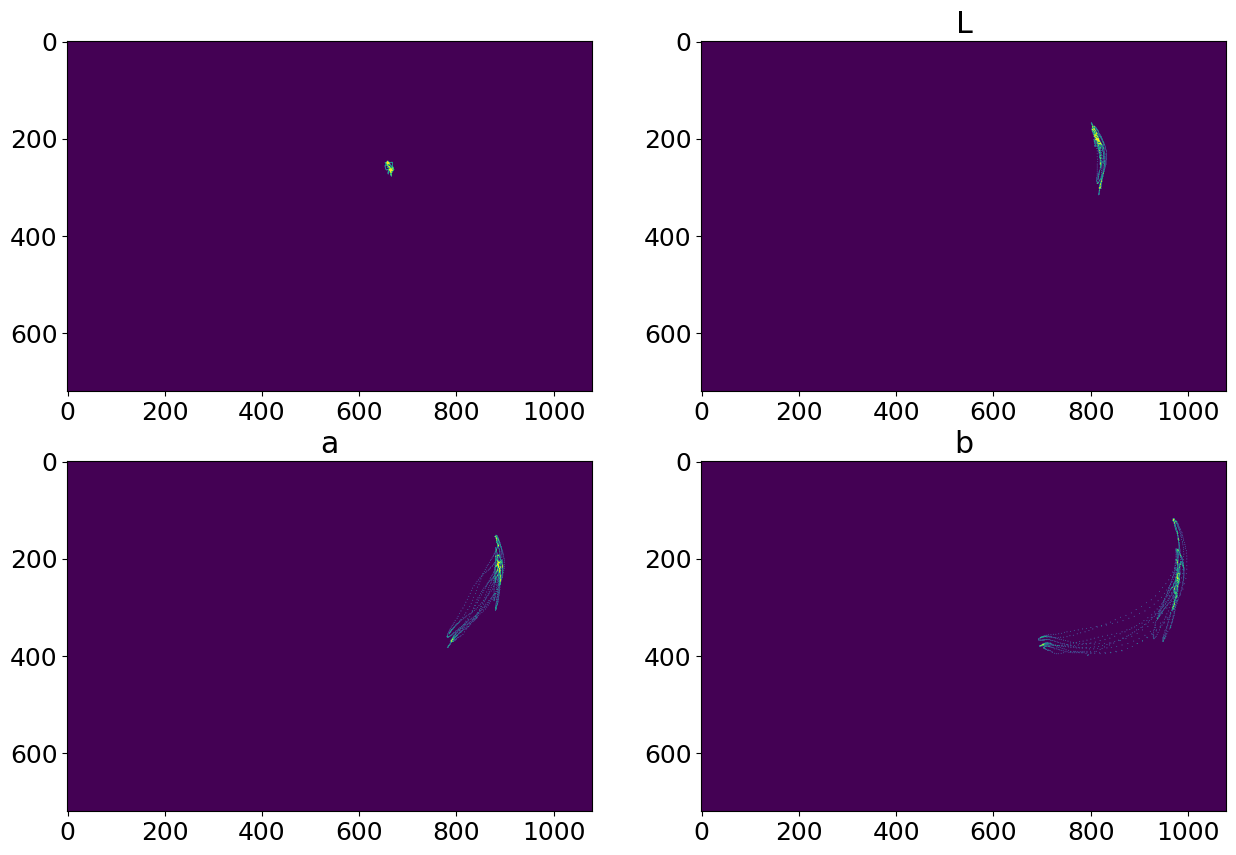

In [28]:
plt.figure(figsize= (15, 10))
plt.rcParams['font.size']=18
plt.subplot(221)
plt.imshow(matrix_of_points_trajectory[0]>0)
plt.subplot(222)
plt.imshow(matrix_of_points_trajectory[1]>0)
# plt.colorbar()
plt.title('L')
plt.subplot(223)
plt.imshow(matrix_of_points_trajectory[2]>0)
# plt.colorbar()
plt.title('a')
plt.subplot(224)
plt.imshow(matrix_of_points_trajectory[3]>0)
# plt.colorbar()
plt.title('b')

In [194]:
colors

[(255, 0, 0), (127, 0, 255), (0, 127, 0), (0, 127, 255)]

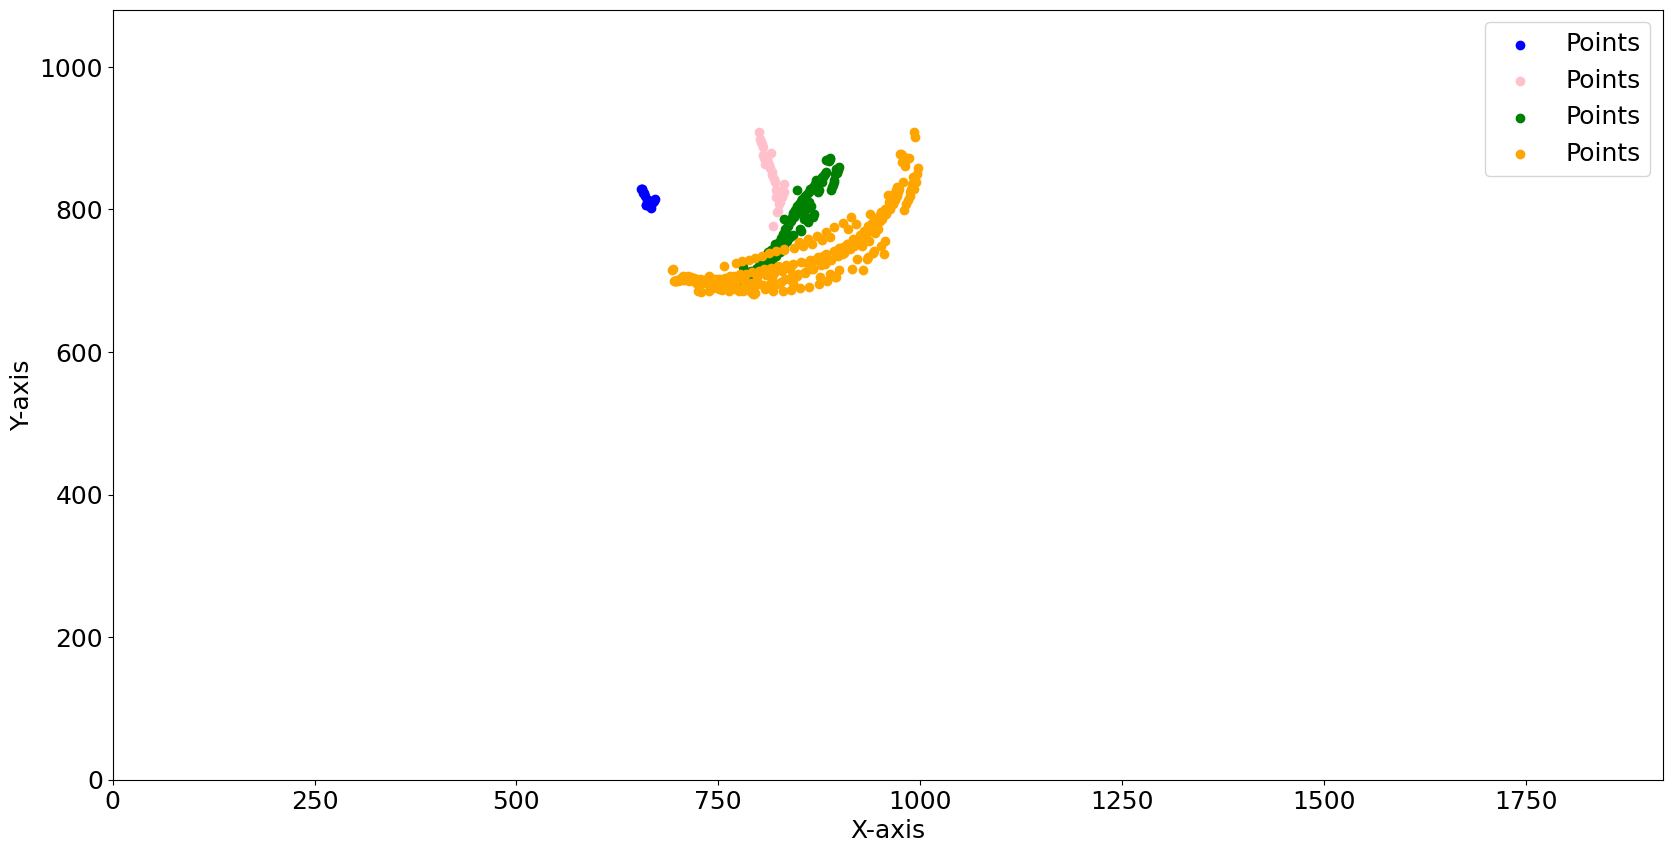

In [29]:
# Create a curve using numpy's polyfit function
degree = 4  # You can adjust the degree of the polynomial
from scipy.interpolate import interp1d
colorss = ["blue", "pink", "green", "orange"]
plt.figure(figsize=(20,10))
for index in range(0,len(trajectory_points_name)):
    pp = trajectory_points_name[index]

    unique_indices = np.unique(df_angle_filter[pp[0]], return_index=True)[1]
    # Create a cubic spline interpolation

    x_points_unique = (np.array(df_angle_filter[pp[0]])[unique_indices])
    y_points_unique = (np.array(df_angle_filter[pp[1]])[unique_indices]- 1080) * -1

    # Create a cubic spline interpolation
    spline_interp = interp1d(x_points_unique, y_points_unique, kind='cubic')

    # Define the range for the curve within the existing points
    x_min, x_max = min(x_points_unique), max(x_points_unique)

    # Generate x values for the curve within the specified range
    x_curve = np.linspace(x_min, x_max, 3)



    # Plot the points and the curve
    plt.scatter(x_points_unique, y_points_unique, label='Points', color=colorss[index])
    # plt.plot(x_curve, spline_interp(x_curve), label='Cubic Spline', color='red')

# Add labels and legend
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()

In [166]:
df_angle_filter[pp[0]]

400    1003
401    1005
402    1007
403    1009
404    1011
       ... 
583    1340
584    1340
585    1340
586    1340
587    1340
Name: i_p_3_x, Length: 188, dtype: int64

In [167]:
unique_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,  43,
        44,  45,  47,  48,  49,  50,  51, 175, 169, 166, 162, 160, 158,
        52, 156, 155, 153, 151, 149,  54, 102, 100, 143,  95,  93,  56,
        57, 139, 138,  58,  59, 134, 132, 131,  60,  61, 129, 128,  62,
       126,  63, 125,  64,  65, 123,  66,  67,  68,  69,  70, 115, 113,
        72, 111,  74,  75,  76,  77,  79,  80,  81,  82,  83,  85,  87,
        89])

801 832 169 317


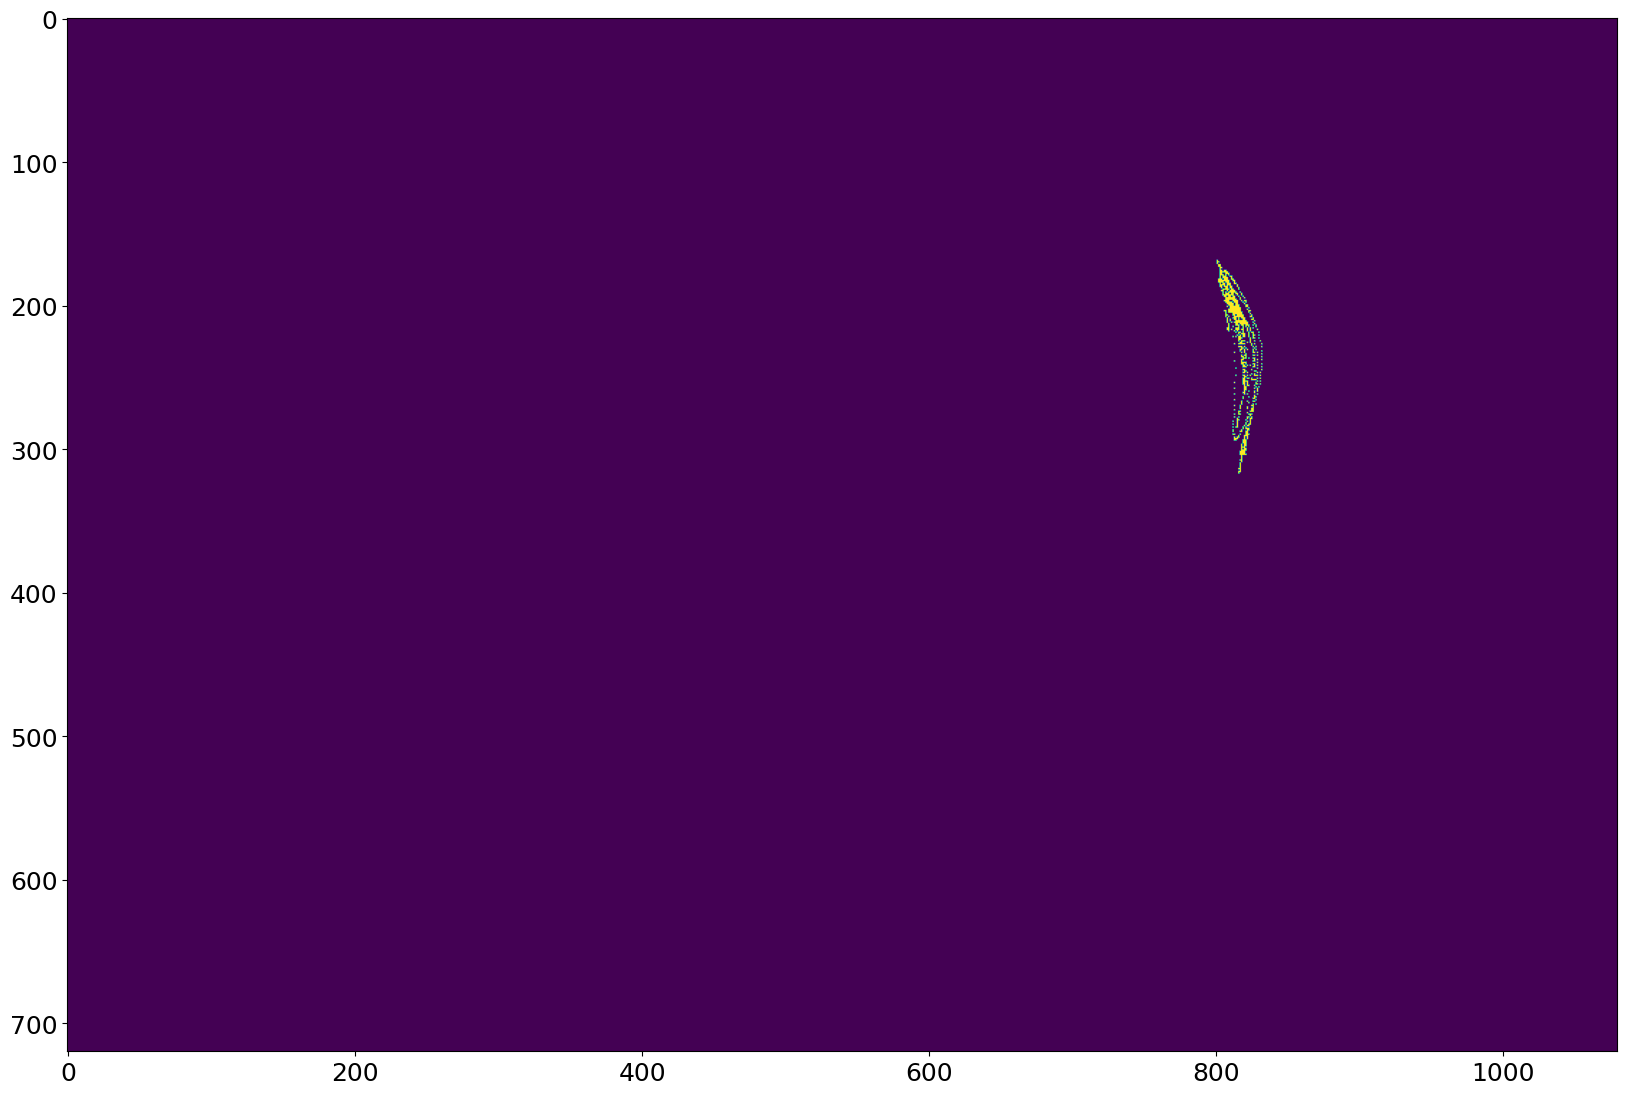

In [35]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_1_x"], df_angle_filter["i_p_1_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_1_x"])
max_x = max(df_angle_filter["i_p_1_x"])
min_y = min(df_angle_filter["i_p_1_y"])
max_y = max(df_angle_filter["i_p_1_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((max_y - min_y + 1, max_x - min_x + 1), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y - min_y, x - min_x] = 1  # Adjust indices to fit within the matrix
# Create a matrix with zeros
matrix = np.zeros((720,1080), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix>0)
# # Print the matrix
# print(matrix)

654 672 248 279


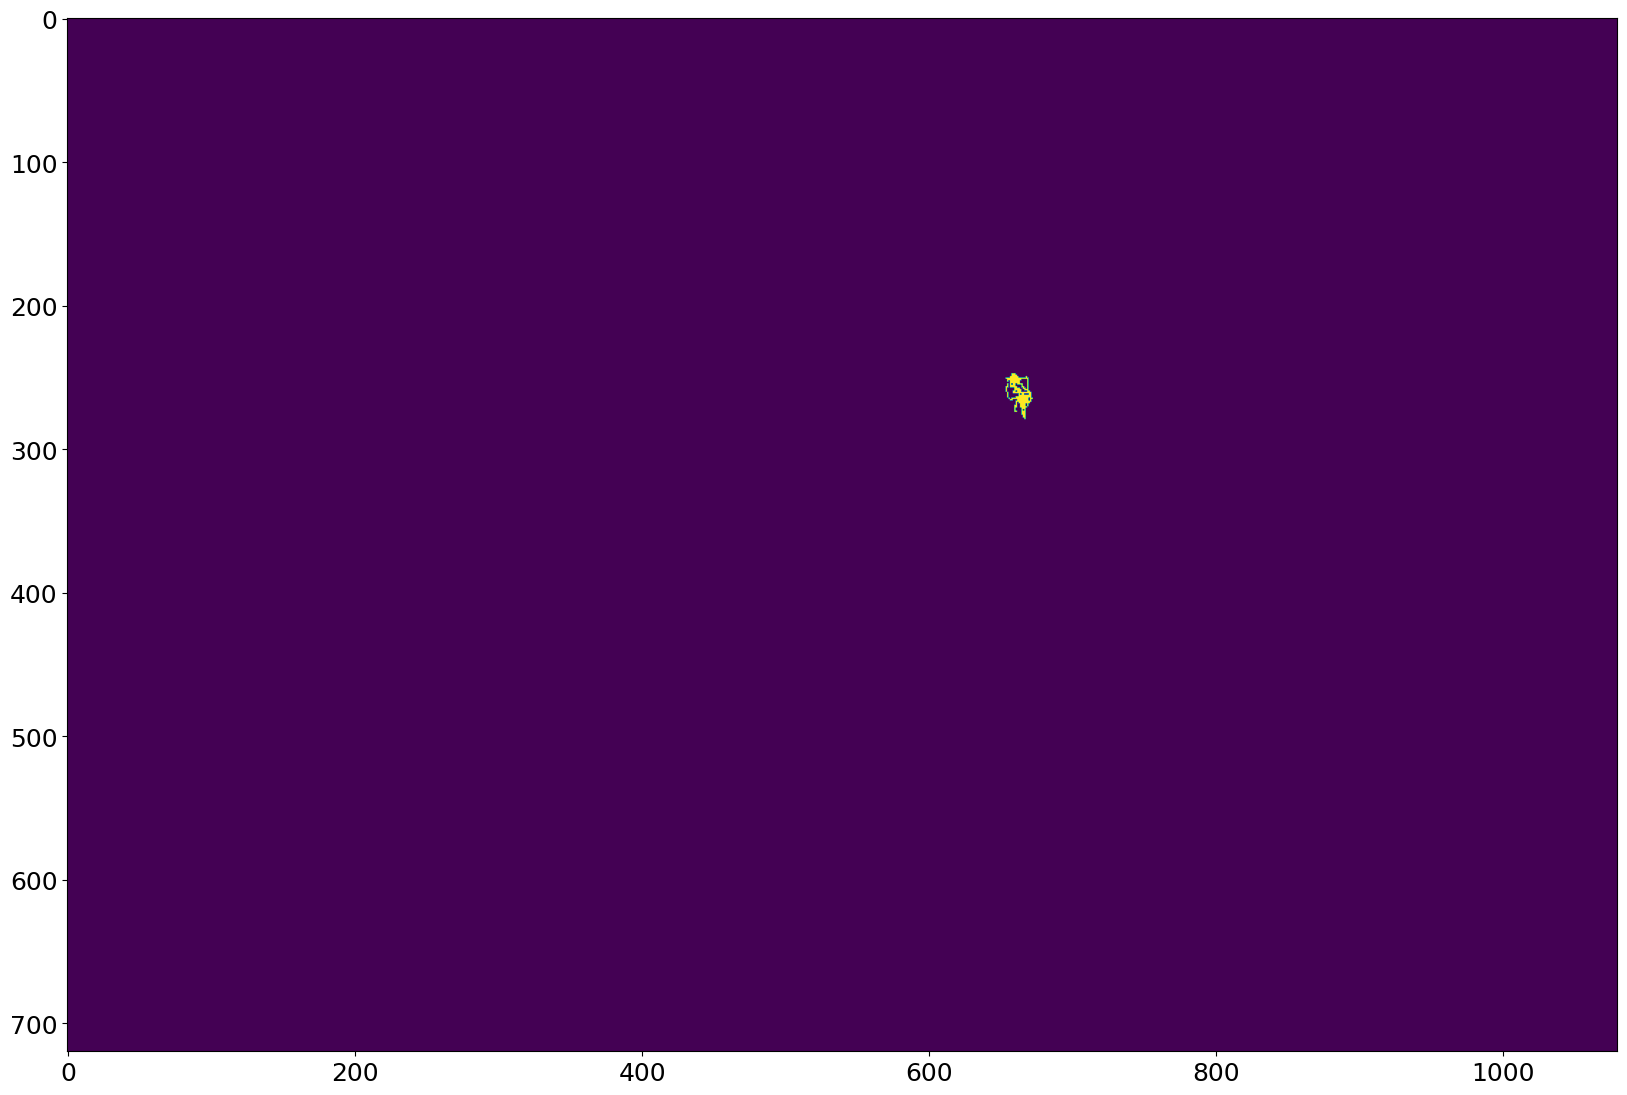

In [36]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_0_x"], df_angle_filter["i_p_0_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_0_x"])
max_x = max(df_angle_filter["i_p_0_x"])
min_y = min(df_angle_filter["i_p_0_y"])
max_y = max(df_angle_filter["i_p_0_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((720,1080), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)

693 997 118 399


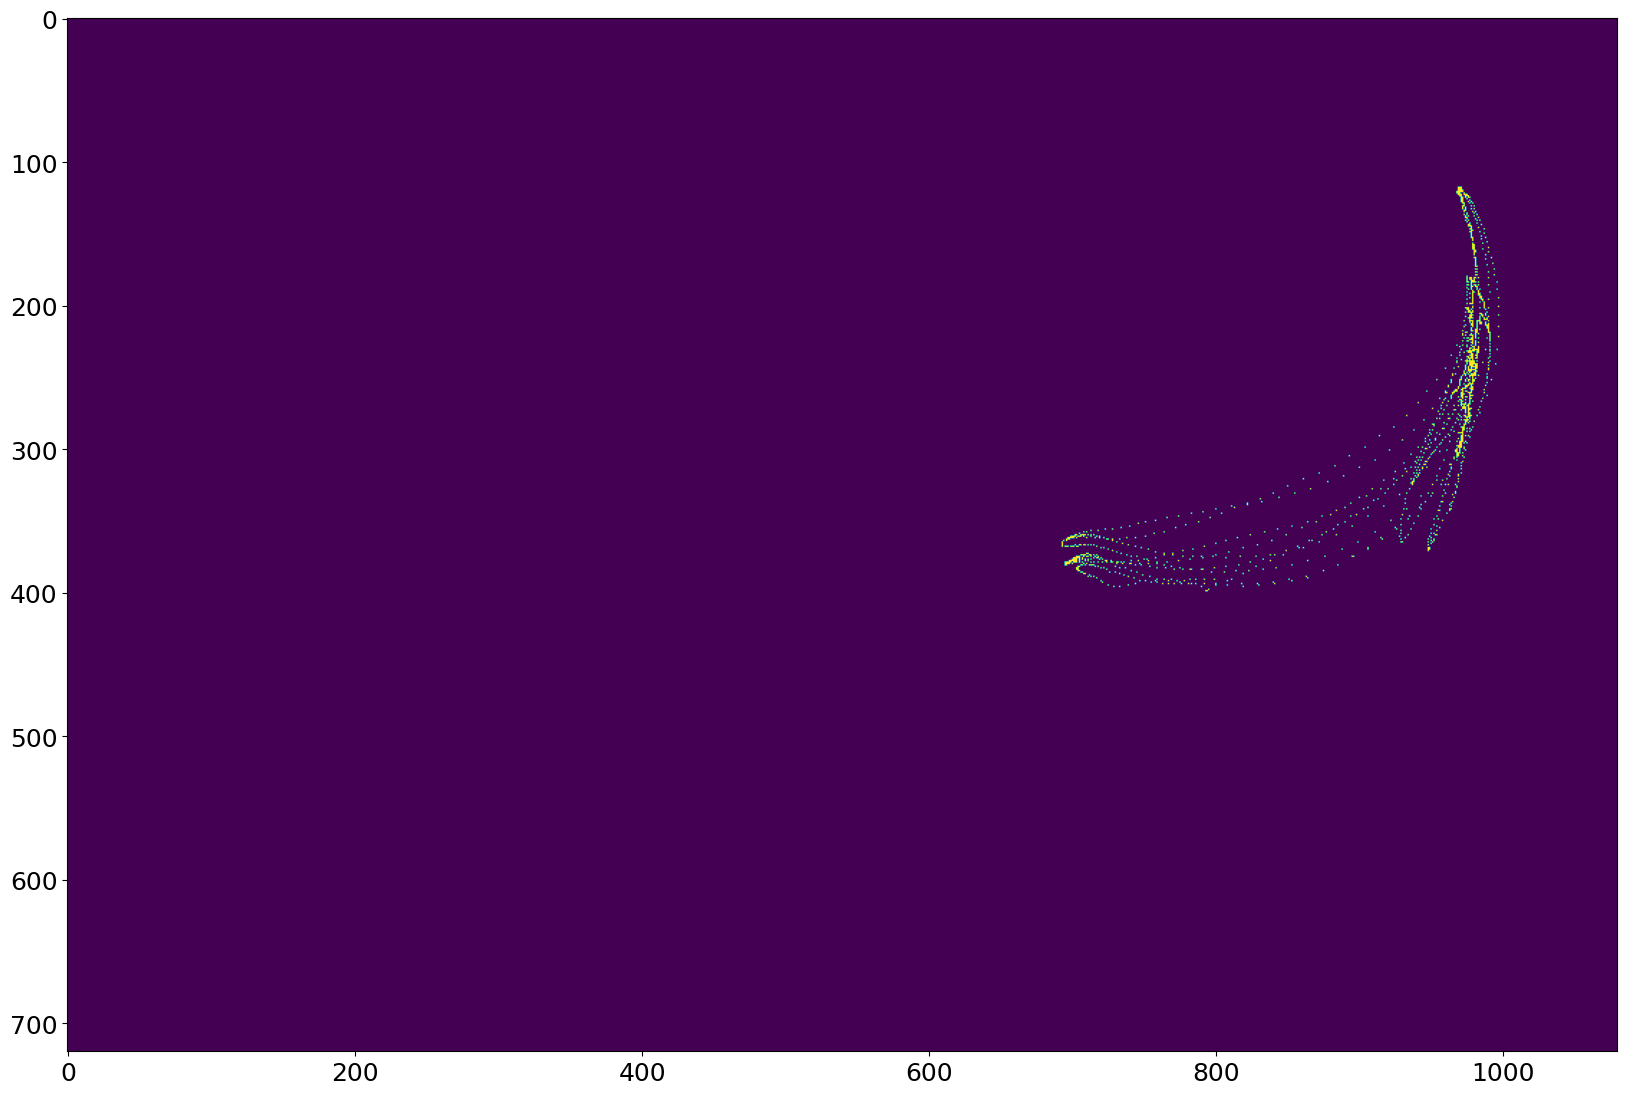

In [37]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_3_x"], df_angle_filter["i_p_3_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_3_x"])
max_x = max(df_angle_filter["i_p_3_x"])
min_y = min(df_angle_filter["i_p_3_y"])
max_y = max(df_angle_filter["i_p_3_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((720,1080), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)

801 832 169 317


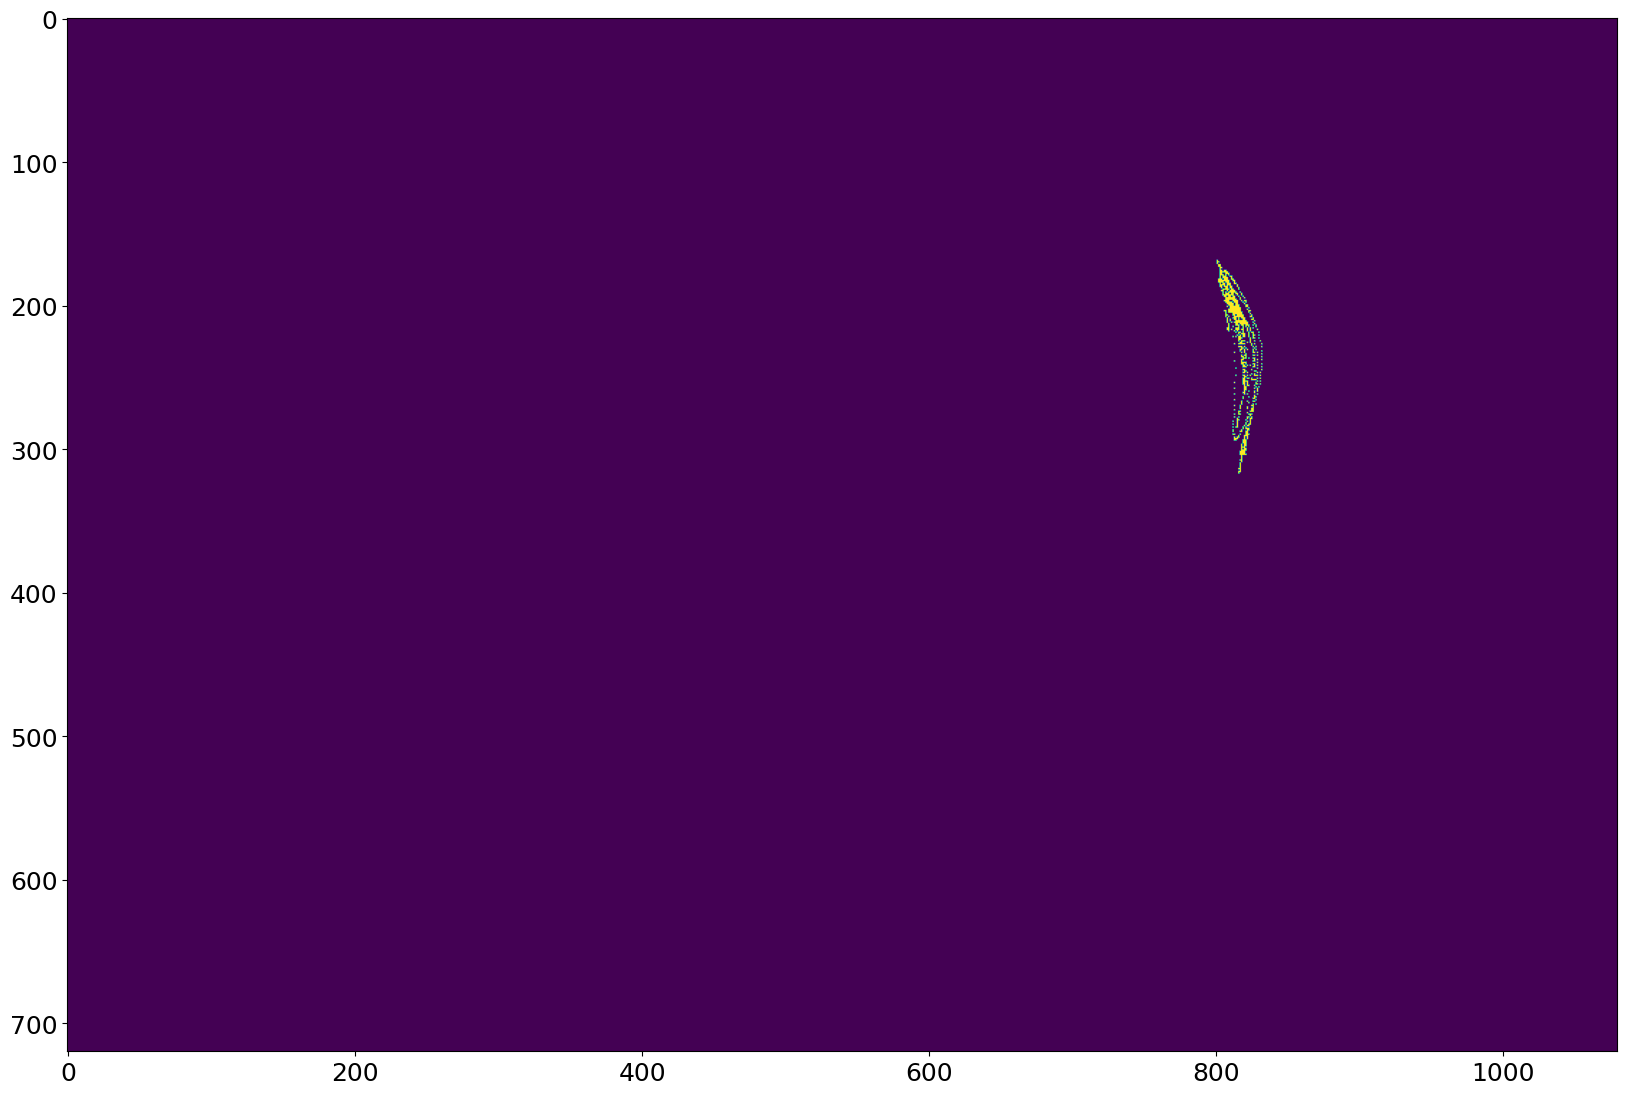

In [38]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_1_x"], df_angle_filter["i_p_1_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_1_x"])
max_x = max(df_angle_filter["i_p_1_x"])
min_y = min(df_angle_filter["i_p_1_y"])
max_y = max(df_angle_filter["i_p_1_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((720,1080), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)

781 899 152 383


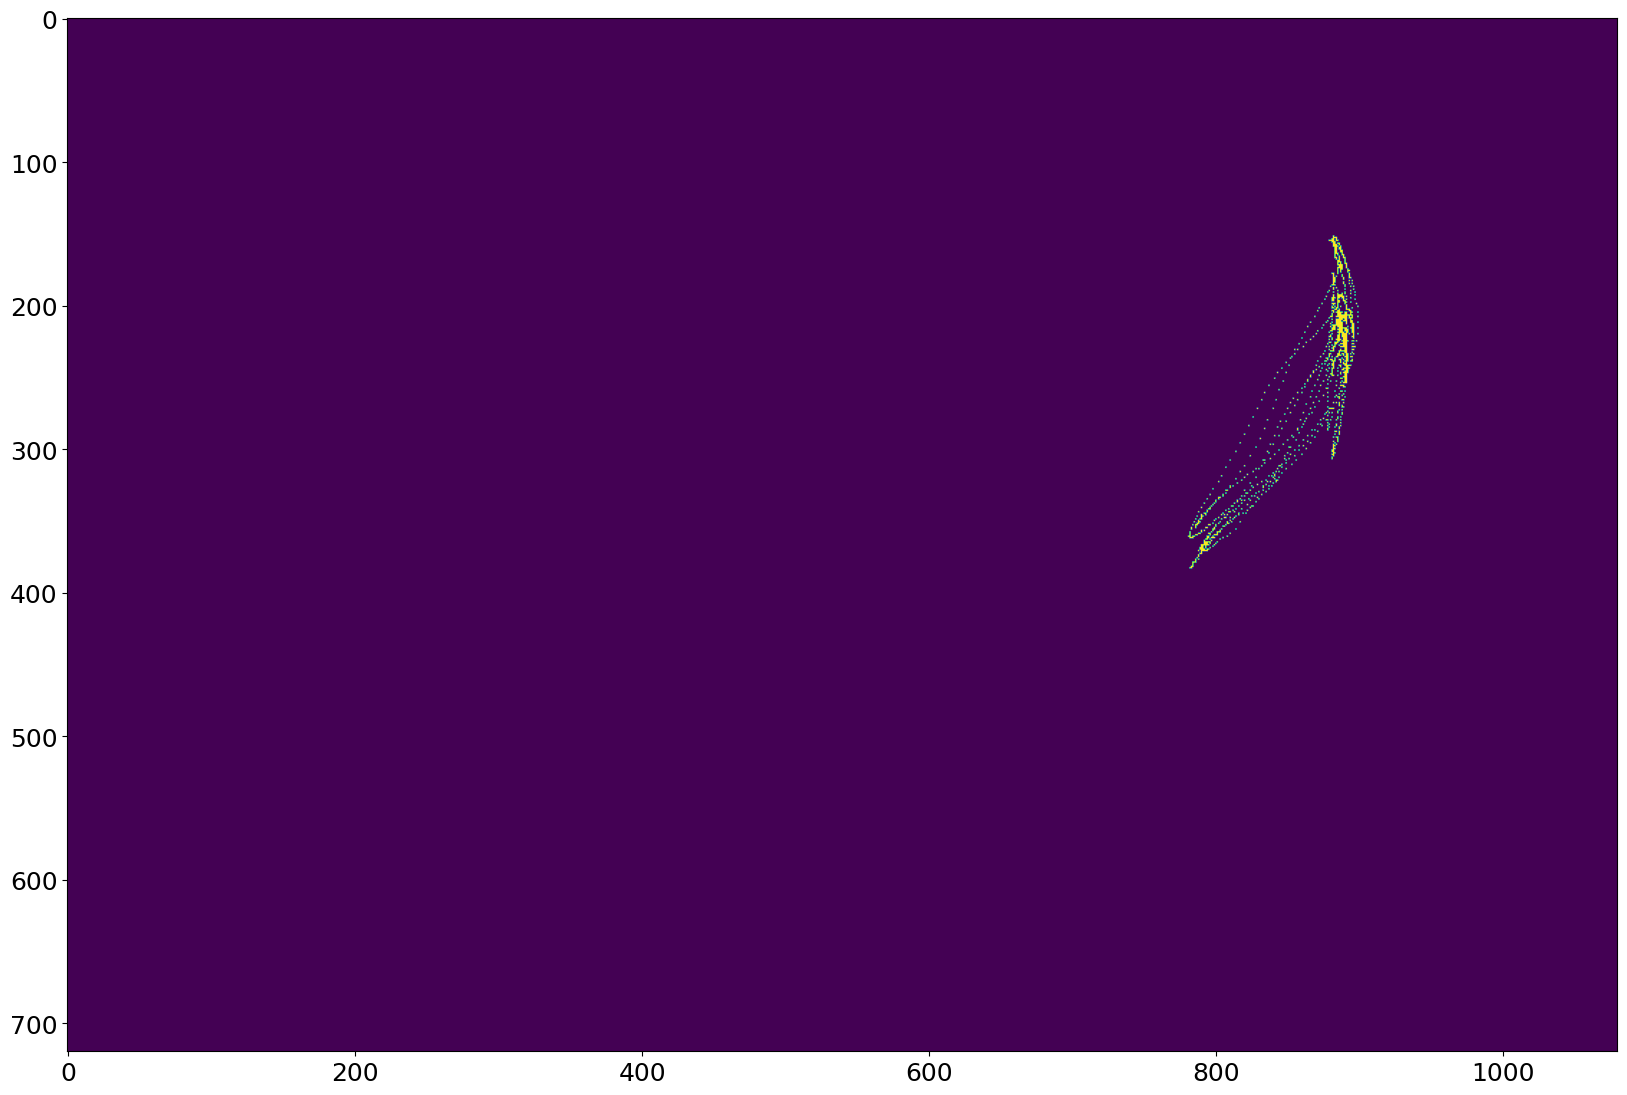

In [39]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_2_x"], df_angle_filter["i_p_2_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_2_x"])
max_x = max(df_angle_filter["i_p_2_x"])
min_y = min(df_angle_filter["i_p_2_y"])
max_y = max(df_angle_filter["i_p_2_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((720,1080), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)